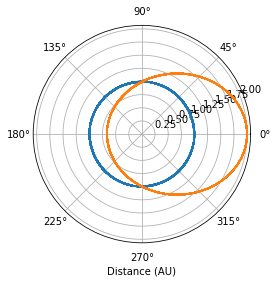

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 17 17:01:26 2020

@author: aswart
"""

# python 3 version 2/15
import numpy as np
import matplotlib.pyplot as plt

def rk4(x,t,tau,derivsRK,planet,output_list):
#%  Runge-Kutta integrator (4th order)
#% Input arguments -
#%   x = current value of dependent variable
#%   t = independent variable (usually time)
#%   tau = step size (usually timestep)
#%   derivsRK = right hand side of the ODE; derivsRK is the
#%             name of the function which returns dx/dt
#%             Calling format derivsRK(x,t).
#% Output arguments -
#%   xout = new value of x after a step of size tau
    half_tau = 0.5*tau
    F1 = derivsRK(x,t,planet,output_list)
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    F2 = derivsRK(xtemp,t_half,planet,output_list)
    xtemp = x + half_tau*F2
    F3 = derivsRK(xtemp,t_half,planet,output_list)
    t_full = t + tau
    xtemp = x + tau*F3
    F4 = derivsRK(xtemp,t_full,planet,output_list)
    xout = x + tau/6.*(F1 + F4 + 2.*(F2+F3))
    return xout


def rka(planet,t,tau,err,derivsRK,output_list):

#% Adaptive Runge-Kutta routine
#% Inputs
#%   x          Current value of the dependent variable
#%   t          Independent variable (usually time)
#%   tau        Step size (usually time step)
#%   err        Desired fractional local truncation error
#%   derivsRK   Right hand side of the ODE; derivsRK is the
#%              name of the function which returns dx/dt
#%              Calling format derivsRK(x,t).
#% Outputs
#%   xSmall     New value of the dependent variable
#%   t          New value of the independent variable
#%   tau        Suggested step size for next call to rka

#%* Set initial variables
    x = planet['state']
    
    tSave = t;  xSave = x    # Save initial values
    safe1 = .9;  safe2 = 4.  # Safety factors
    eps = np.spacing(1) # smallest value
    


#%* Loop over maximum number of attempts to satisfy error bound
    maxTry = 100

    for iTry in range(1,maxTry):
	
#%* Take the two small time steps
        half_tau = 0.5 * tau
        xTemp = rk4(xSave,tSave,half_tau,derivsRK,planet,output_list)
        t = tSave + half_tau
        xSmall = rk4(xTemp,t,half_tau,derivsRK,planet,output_list)
  
  #%* Take the single big time step
        t = tSave + tau
        xBig = rk4(xSave,tSave,tau,derivsRK,planet,output_list)
  
  #%* Compute the estimated truncation error
        scale = err * (np.abs(xSmall) + np.abs(xBig))/2.
        xDiff = xSmall - xBig
        errorRatio = np.max( [np.abs(xDiff)/(scale + eps)] )
        
        #print safe1,tau,errorRatio
  
  #%* Estimate news tau value (including safety factors)
        tau_old = tau

        tau = safe1*tau_old*errorRatio**(-0.20)
        tau = np.max([tau,tau_old/safe2])
        tau = np.min([tau,safe2*tau_old])
  
  #%* If error is acceptable, return computed values
        if errorRatio < 1 : 
          # xSmall = xSmall #% +  (xDiff)/15
          #   xSmall = (16.*xSmall - xBig)/15. # correction
            return xSmall, t, tau  

#%* Issue error message if error bound never satisfied
    print ('ERROR: Adaptive Runge-Kutta routine failed')
    return
def gravrk(s,t,planet,output_list):
#%  Returns right-hand side of Kepler ODE; used by Runge-Kutta routines
#%  Inputs
#%    s      State vector [r(1) r(2) v(1) v(2)]
#%    t      Time (not used)
#%  Output
#%    deriv  Derivatives [dr(1)/dt dr(2)/dt dv(1)/dt dv(2)/dt]

    GM = 4*np.pi**2
    
#%* Compute acceleration
    r = np.array([s[0], s[1]])  # Unravel the vector s into position and velocity
    v = np.array([s[2] ,s[3]])
    accel = -GM*r/np.linalg.norm(r)**3  # Gravitational acceleration
    
    # find accel due to other planets
    planet_accel = 0
    #print(planet)
    ''' # Didnt have time to debug n-body accelearation, ran out of time
    for i in output_list:
        #print(i)
        if i != planet:
            #print(i)
            r_prime = i['r'] - planet['r']
            g = - (GM*i['mass']*planet['mass']*r_prime)/np.linalg.norm(r_prime)**3
    '''
#%* Return derivatives [dr(1)/dt dr(2)/dt dv(1)/dt dv(2)/dt]
    derivs = np.array([v[0], v[1], accel[0], accel[1]])
    return derivs

# orbit - Program to compute the orbit of a comet.
"""
Planning:
    Input:
    Takes list of objects
    Each object has a dict that states:
        radius (r0)
        velocity (v0)
        mass (mass)
    tau and nSteps is directly passed in
    
    Output:
    Iterate over array and build inital value arrays for each planet
    each planet is a dict in a list
    dict contains variables with standard names as from orbit.py as keys
    values for each key are lists
    
"""
def orbit(tau, nStep, input_list = [],calc_info = False, plot_momentum = False,
           plot_traj = True, plot_energy = False):        

    if input_list:
        output_list = []
        for planet in input_list:  # planet in input list is tuple of (r0,v0,mass0)
            r = np.array([planet[0], 0.])
            v = np.array([0., planet[1]])
            state = np.array([ r[0], r[1], v[0], v[1] ])
            mass = planet[2]
            output_list.append({'r' : r, 'v' : v,'state': state, 'mass': mass})
            #print(planet)
    else:
        raise Exception("Please enter input values")


    
    #Set physical parameters (mass, G*M)
    GM = 4*np.pi**2      # Grav. const. * Mass of Sun (au^3/yr^2)
    adaptErr = 1.e-4 # Error parameter used by adaptive Runge-Kutta
    time = 0.0
    
    #%* Loop over desired number of steps using specified
    #%  numerical method.
    for istep in range(0,nStep):
        
        if istep == 0:
            tplot = time
        else:
            tplot = np.append(tplot,time)
            
            
        for planet in output_list:
            #%* Record position and energy for plotting.
            # Initially set the arrays for the first step
            if istep == 0:
                
                rplot = np.linalg.norm(planet['r'])
                thplot = np.arctan2(planet['r'][1],planet['r'][0])
                kinetic = .5*planet['mass']*np.linalg.norm(planet['v'])**2
                potential = - GM*planet['mass']/np.linalg.norm(planet['r'])
                momentum = [np.linalg.norm(np.cross(planet['r'],planet['mass']*planet['v']))]

                planet["rplot"] = rplot
                planet['thplot'] = thplot
                planet['kinetic'] = kinetic
                planet['potential'] = potential
                planet['momentum'] = momentum
                
            else:    
                
                planet["rplot"]  = np.append(planet["rplot"] ,np.linalg.norm(planet['r']))           #Record position for polar plot
                planet['thplot'] = np.append(planet['thplot'],np.arctan2(planet['r'][1],planet['r'][0]))
                planet['kinetic']  = np.append(planet['kinetic'] ,0.5*planet['mass']*np.linalg.norm(planet['v'] )**2)   # Record energies
                planet['potential'] = np.append(planet['potential'], -GM*planet['mass']/np.linalg.norm(planet['r']))
                planet['momentum'].append(np.linalg.norm(np.cross(planet['r'], planet['mass']*planet['v'])))
    
            #%* Calculate new position and velocity using Adaptive RK4
            #print(planet,'\n\n')
            [state, time, tau] = rka(planet,time,tau,adaptErr,gravrk,output_list)
            r = np.array([state[0], state[1]])   # Adaptive Runge-Kutta
            v = np.array([state[2], state[3]])
            planet['state'] = state
            planet['r'] = r
            planet['v'] = v
          
            
    if plot_traj:
        #%* Graph the trajectory of the comet.
        plt.figure(1); plt.clf()  #Clear figure 1 window and bring forward
        for planet in output_list:
            plt.polar(planet['thplot'],planet['rplot'],'-')  # Use polar plot for graphing orbit
        plt.xlabel('Distance (AU)')
        plt.grid(True)
    
    if plot_energy:
        #%* Graph the energy of the comet versus time.
        plt.figure(2); plt.clf()   # Clear figure 2 window and bring forward
        totalE = kinetic + potential   # Total energy
        plt.plot(tplot,kinetic,'-.',tplot,potential,'--',tplot,totalE,'-')
        #plt.legend('Kinetic','Potential','Total')
        plt.xlabel('Time (yr)'); plt.ylabel('Energy (M AU^2/yr^2)')
        plt.grid(True)
        plt.show()

   
    

    return rplot, thplot

if __name__ == "__main__":
    # non-elliptical
    # List of input tuples values is (r0,v0,mass) mass is in relative units to sun
    #input_list = [(1,2*np.pi,3.003489*10**-6),(5.2,123.36*np.pi,954.79194*10**-6)] #Earth, jupiter
    input_list = [(1,2*np.pi,1),(2,1*np.pi,1)]
    
    rplot, thplot  = orbit(.01,1000, input_list)
